In [ ]:
#x01_populationStatistics

In [ ]:
import matplotlib.pyplot as plt
import uuid
import pdb
import torch
from matplotlib.animation import FuncAnimation
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import gymnasium as gym
import numpy as np
device='cpu'
from torch.utils.tensorboard import SummaryWriter

from chewc.sim import *
from chewc.callback import *
from chewc.policy import *

In [ ]:

import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv


In [ ]:

# Assuming `SelectionIntensityEnvironment` is defined as per your provided context
class SelectionIntensityEnvironment(gym.Env):
    def __init__(self, SP, config):
        super(SelectionIntensityEnvironment, self).__init__()
        self.SP = SP
        self.config = config  # Store the config
        self.current_generation = 0
        self.max_generations = SP.max_generations
        # Get action space bounds from config, with defaults if not provided
        
        self.action_low = config.get('action_low', 0.05)
        self.action_high = config.get('action_high', 0.95)
        
        # Update action space with custom bounds
        self.action_space = gym.spaces.Box(
            low=np.array([-1]), 
            high=np.array([1]), 
            dtype=np.float32
        )
        
        self.observation_space = gym.spaces.Dict({
            "population": gym.spaces.Box(low=0, high=1, shape=(self.SP.pop_size, 2, self.SP.G.n_chr, self.SP.G.n_loci), dtype=np.int32),
            "generation": gym.spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32)
        })
        # logging
        self.action_values = []
        self.genetic_variance = []
        self.max_breeding_values = []
        self.final_generations = []
        self.episode_count = 0
        self.rewards = []
        self.episode_reward = 0
        
        #config
        self.config =config
        
    def update_max_generations(self, new_max_gen):
        self.max_generations = new_max_gen
        self.SP.max_generations = new_max_gen
        # Update observation space if necessary
        self.observation_space = gym.spaces.Dict({
            "population": gym.spaces.Box(low=0, high=1, shape=(self.SP.pop_size, 2, self.SP.G.n_chr, self.SP.G.n_loci), dtype=np.int32),
            "generation": gym.spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32)
        })
        
    def _get_obs(self):
        population = self.population.haplotypes.cpu().numpy().astype(np.int32)
        generation = np.array([self.current_generation / self.SP.max_generations], dtype=np.float32)
        return {"population": population, "generation": generation}

    def _get_info(self):
        return {
            "max_phenotype": self.population.breeding_values.max().cpu().item(),
            "genetic_variance": self.population.breeding_values.var().cpu().item(),
            "current_generation": self.current_generation
        }

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.population = self.SP.founder_pop
        self.phenotype = phenotype(self.population, self.SP.T, self.SP.h2)
        self.current_generation = 0
        self.episode_reward = 0
        observation = self._get_obs()
        info = self._get_info()
        return observation, info

    def step(self, action):
        
        # Map the action from [-1, 1] to [action_low, action_high]
        action = scale_values(action, to_range=(self.action_low, self.action_high))
#         print(action)

        # Ensure action_scalar is within bounds
        total_selected = max((2,int(action * self.population.size)))
#         print(f'total selected {total_selected}')
#         action_scalar = np.clip(action_scalar, self.action_low, self.action_high)
        selected = torch.topk(self.population.phenotypes, total_selected).indices
        self.population = create_pop(self.SP.G, random_crosses(self.population.haplotypes[selected], self.SP.pop_size))
        self.phenotype = phenotype(self.population, self.SP.T, self.SP.h2)
        self.current_generation += 1

        observation = self._get_obs()
        info = self._get_info()
        info['normalized_action'] = action


        
        terminated = self.current_generation >= self.SP.max_generations
        #REWARD
        if self.config.get('sparse_reward', False):  # Use .get() with a default value
            reward = 0 if not terminated else float(self.population.breeding_values.max())
        else:
            reward = float(self.population.breeding_values.max())
        self.episode_reward += reward

        if terminated:
            info['final_generation'] = {
            "max_phenotype": self.population.breeding_values.max().cpu().item(),
            "genetic_variance": self.population.breeding_values.var().cpu().item(),
            "current_generation": self.current_generation
            }

        return observation, reward, bool(terminated), False, info



In [ ]:
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import CallbackList
from stable_baselines3.common.vec_env import DummyVecEnv
import random


# Example usage
n_chr = 1
n_parents = 20
n_loci = 500
founder_pop_size = 50
h2 = 1
reps = 1
max_generations = 10
seed = 422  # Choose any integer for your seed
G = Genome(n_chr, n_loci, seed=seed)



#set up the initial population

founder_haplotypes = np.load('./data/g2f_ch10.npy') 
random_parent_indicies =  np.random.choice(founder_haplotypes.shape[0], n_parents, replace=False)
random_loci_indices = np.random.choice(founder_haplotypes.shape[2], n_loci, replace=False)
founder_haplotypes = founder_haplotypes[random_parent_indicies,:,:]
founder_haplotypes = founder_haplotypes[:,:,random_loci_indices]
founder_haplotypes = torch.tensor(founder_haplotypes)
founder_haplotypes = founder_haplotypes.unsqueeze(2) 


founder_pop = create_pop(G, founder_haplotypes)
founder_pop = random_crosses(founder_pop.haplotypes,founder_pop_size)
founder_pop = create_pop(G, founder_pop)



T = Trait(G, founder_pop, target_mean=0.0, target_variance=1.0, seed=seed)
SP = SimParams(G, T, h2, reps, founder_pop_size, max_generations, founder_pop, seed=seed)


# Create your custom callbacks
genetic_variance_callback = AverageFinalGenerationCallback(log_freq=100)
action_callback = ActionTrackingCallback(log_freq=10)

# Combine the callbacks using CallbackList
combined_callbacks = CallbackList([genetic_variance_callback, action_callback])

# Create the environment
config = {'sparse_reward':True}
env = SelectionIntensityEnvironment(SP, config)
x = env.reset()

Summary Statistics:
Mean: 0.49
Median: 0.52
Standard Deviation: 0.99
Minimum: -2.06
Maximum: 2.84
Sum: 24.40


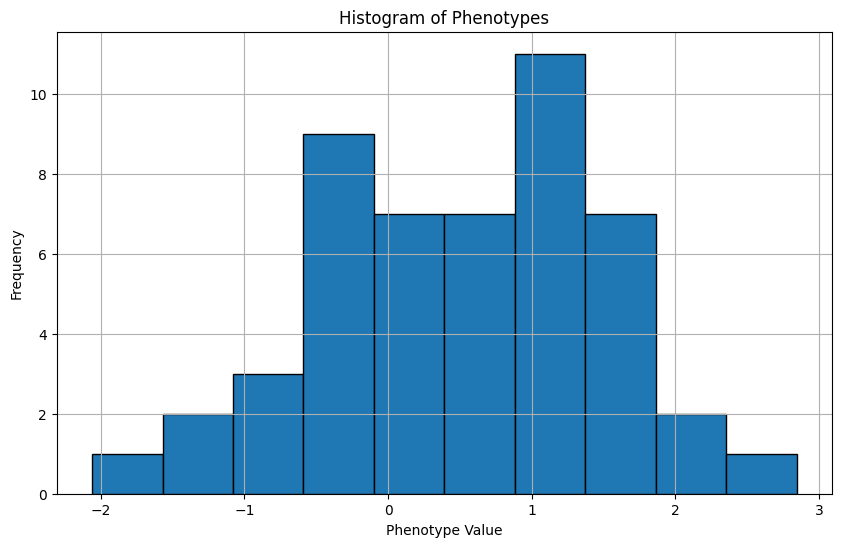

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Convert torch tensor to numpy array if necessary
phenotypes = env.population.breeding_values.numpy()

# Calculate summary statistics
mean_phenotype = np.mean(phenotypes)
median_phenotype = np.median(phenotypes)
std_phenotype = np.std(phenotypes)
min_phenotype = np.min(phenotypes)
max_phenotype = np.max(phenotypes)
sum_phenotype = np.sum(phenotypes)

# Print summary statistics
print("Summary Statistics:")
print(f"Mean: {mean_phenotype:.2f}")
print(f"Median: {median_phenotype:.2f}")
print(f"Standard Deviation: {std_phenotype:.2f}")
print(f"Minimum: {min_phenotype:.2f}")
print(f"Maximum: {max_phenotype:.2f}")
print(f"Sum: {sum_phenotype:.2f}")

# Create histogram
plt.figure(figsize=(10, 6))
plt.hist(phenotypes, bins=10, edgecolor='black')
plt.title('Histogram of Phenotypes')
plt.xlabel('Phenotype Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

[tensor(-1.), tensor(0.), tensor(0.8889)]


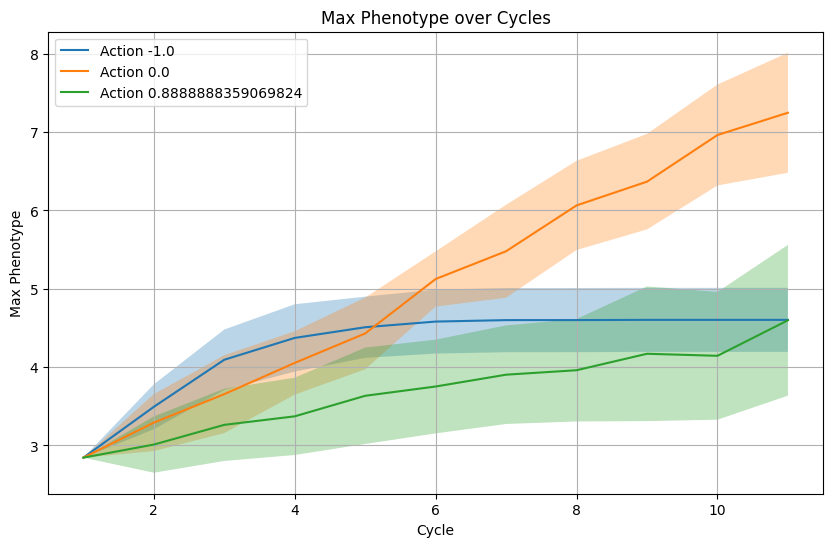

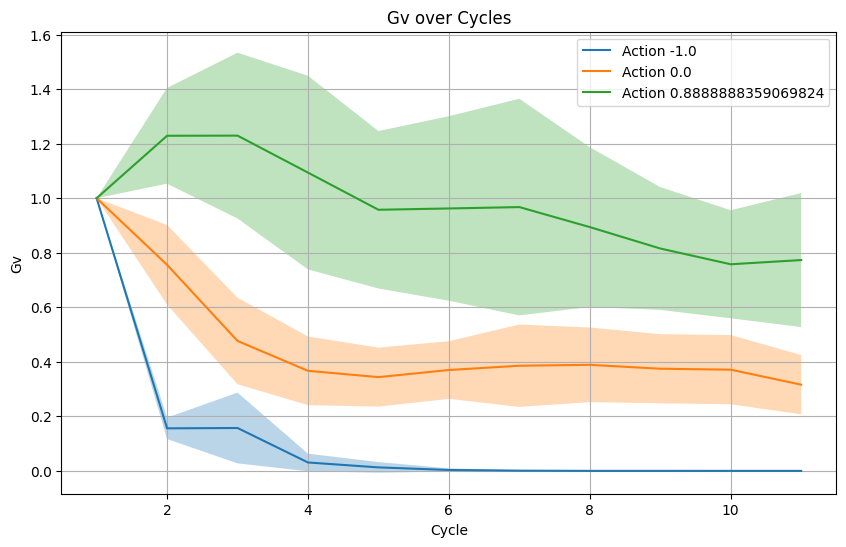

[tensor(-1.), tensor(0.), tensor(0.8889)]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming SimulatedEnv and Population classes are already defined as in your code

def collect_baselines(env, actions, repetitions=100, cycles=5):
    results = {action: {'max_phenotype': [], 'gv': []} for action in actions}
    
    for action in actions:
        for _ in range(repetitions):
            env.reset()
            cycle_max_phenotype = []
            cycle_gv = []
            max_phenotype = env.population.breeding_values.max()
            gv = env.population.breeding_values.var()
            cycle_max_phenotype.append(max_phenotype)
            cycle_gv.append(gv)
            for _ in range(cycles):
                env.step(np.array(action))
                max_phenotype = env.population.breeding_values.max()
                gv = env.population.breeding_values.var()
                cycle_max_phenotype.append(max_phenotype)
                cycle_gv.append(gv)
            
            results[action]['max_phenotype'].append(cycle_max_phenotype)
            results[action]['gv'].append(cycle_gv)
    
    return results

def plot_results(results, metric):
    plt.figure(figsize=(10, 6))
    
    for action, data in results.items():
        mean_values = np.mean(data[metric], axis=0)
        std_values = np.std(data[metric], axis=0)
        cycles = range(1, len(mean_values) + 1)
        
        plt.plot(cycles, mean_values, label=f'Action {action}')
        plt.fill_between(cycles, mean_values - std_values, mean_values + std_values, alpha=0.3)
    
    plt.xlabel('Cycle')
    plt.ylabel(metric.replace('_', ' ').title())
    plt.title(f'{metric.replace("_", " ").title()} over Cycles')
    plt.legend()
    plt.grid(True)
    plt.show()

# Set up the environment and actions
actions = [.05, .5, .9 ]
actions = [scale_values(x, to_range=(-1, 1), from_range=(env.action_low, env.action_high)) for x in actions]
print(actions)
# Collect baselines
results = collect_baselines(env, actions, repetitions=30,cycles=SP.max_generations)

# Plot results
plot_results(results, 'max_phenotype')
plot_results(results, 'gv')
print(actions)

In [ ]:
env.reset()

({'population': array([[[[1, 0, 1, ..., 0, 1, 0]],
  
          [[0, 0, 0, ..., 1, 0, 1]]],
  
  
         [[[1, 0, 1, ..., 0, 1, 0]],
  
          [[1, 1, 0, ..., 0, 0, 0]]],
  
  
         [[[1, 0, 1, ..., 0, 1, 0]],
  
          [[1, 1, 0, ..., 0, 0, 0]]],
  
  
         ...,
  
  
         [[[1, 1, 0, ..., 0, 0, 0]],
  
          [[1, 0, 1, ..., 0, 1, 0]]],
  
  
         [[[0, 0, 0, ..., 0, 0, 0]],
  
          [[1, 0, 1, ..., 0, 1, 0]]],
  
  
         [[[0, 0, 0, ..., 0, 0, 0]],
  
          [[1, 0, 1, ..., 0, 1, 0]]]], dtype=int32),
  'generation': array([0.], dtype=float32)},
 {'max_phenotype': 2.844006299972534,
  'genetic_variance': 0.9999998807907104,
  'current_generation': 0})

In [ ]:
# import torch
# # Wrap the environment (required for SB3)
# env.reset()
# env = DummyVecEnv([lambda: env])

# # Create and train the model with the custom policy
# model = PPO(CustomActorCriticPolicy, env, verbose=1, tensorboard_log="./ppotb")
# model.learn(total_timesteps=500000, callback=combined_callbacks)

In [ ]:

# # Create the environment
# config = {}
# env = SelectionIntensityEnvironment(SP, config)

# # Wrap the environment (required for SB3)
# env = DummyVecEnv([lambda: env])

# # Create and train the model with the custom policy
# model = PPO(CustomActorCriticPolicy, env, verbose=1, tensorboard_log="./ppotb")
# model.learn(total_timesteps=100000, callback=combined_callbacks)

In [ ]:
SP.max_generations

10